In [14]:
%matplotlib inline

import autograd.numpy.random as npr
import autograd.numpy as np
from autograd import grad
from autograd.extend import primitive, defvjp
from autograd.misc.optimizers import adam
import scipy.special.lambertw as lambertw_
import autograd.scipy.stats.norm as norm
import matplotlib.pyplot as plt

In [15]:
lambertw = primitive(lambda x: lambertw_(x, 0).real)
defvjp(lambertw, 
        lambda ans, x: lambda g: g * 1./ (x + np.exp(ans)),
        None 
      )
def slambertw_logpdf_(y, loc, scale, skew, tol = 0.8):
    u = (y - loc)/scale
    if skew != 0:
        cutoff = - tol /(np.e * skew)
        cond = u >= cutoff if skew < 0 else u <= cutoff
        utmp = np.where(cond, cutoff, u)
        wc = lambertw(skew * utmp)
        gc = 1./(np.exp(wc) + skew*utmp)
        z = np.where(cond, wc/skew + (u - cutoff) * gc, wc/skew)
        return norm.logpdf(z) + np.log(gc) - np.log(scale)
    else:
        return norm.logpdf(u) - np.log(scale)

In [16]:
from autograd.test_util import check_grads

x = np.linspace(-3,3,20)
obj = lambda y, loc, scale, skew: np.sum(slambertw_logpdf_(y, loc, scale, skew))

print(obj(x, 0., 1., 0.2))
g = grad(obj)
# check grad
print(g(1., 0., 1., 0.2))
print((obj(1., 0., 1., 0.2) - obj(1.001, 0., 1., 0.2))/-0.001)

-96.716875986
-0.87836736277
-0.878502945211


In [17]:
# generate sample data
N = 1000
D = 100
K = 5
npr.seed(100)
scale = 1.
skew = 0.05
theta_o = theta = npr.randn(N,K) 
beta_o = beta = npr.randn(D,K)
loc = np.matmul(theta, beta.T)
u = npr.randn(N,D)
y = u * np.exp(skew * u) * scale + loc

In [18]:
def make_lambertw_routines(y, skew_function, learn = True, fixed_skew = 0.1):
    def unpack_params(params):
        theta = np.reshape(params[:(N*K)], [N, K])
        beta = np.reshape(params[(N*K):-1], [D, K])
        skew = skew_function(params[-1]) if learn else fixed_skew
        return theta, beta, skew
    
    slambertw_logpdf = lambda loc, scale, skew: slambertw_logpdf_(y, loc, scale, skew, 0.9)

    def objective(params, t):
        theta, beta, skew = unpack_params(params)
        loc = np.matmul(theta, beta.T)
        return -np.sum(slambertw_logpdf(loc, 1., skew))
    
    return objective, slambertw_logpdf, unpack_params

In [25]:
skews = np.linspace(-0.2, 0.2, 9)
logpdfs = np.copy(skews)

skew_tanh = lambda skew: 0.2 * np.tanh(1e-1 * skew)
skew_identity = lambda skew: skew

def callback(params, i, g):
    if not i%100: print(i, objective(params, 0), skew_tanh(params[-1]), params[-1], np.sum(params[:-1]), end ='\r')

# learn thetas and betas for fixed skews 
for i,s in enumerate(skews): 
    npr.seed(200)
    theta_n = npr.randn(N,K) 
    beta_n = npr.randn(D,K) 
    init_params = np.concatenate([theta_n.flatten(),beta_n.flatten(),np.array([-0.001])])
    objective, _, unpack_params = make_lambertw_routines(y, skew_identity, False, s)
    gradient = grad(objective)
    final_params = adam(gradient, init_params, step_size=0.1, num_iters=1000, callback = callback)
    logpdfs[i] = objective(final_params, 0)

 # learn thetas, betas along with the skew, for verifiying if the learnt skew is correct. 
npr.seed(200)
theta_n = npr.randn(N,K) 
beta_n = npr.randn(D,K) 
init_params = np.concatenate([theta_n.flatten(),beta_n.flatten(),np.array([-0.001])])
objective, _, unpack_params = make_lambertw_routines(y, skew_tanh)
gradient = grad(objective)
final_params = adam(gradient, init_params, step_size=0.1, num_iters=1000, callback = callback)
print(objective(final_params, 0))
inf_logpdf = objective(final_params, 0)
_, _, inf_skew = unpack_params(final_params)

# # Inference ends here. 


138610.1649323281 0.057066179354 2.93475914253 165.7767479381


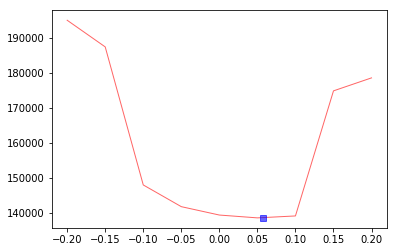

In [34]:
plt.plot(skews, logpdfs, 'r-', inf_skew, inf_logpdf, 'bs', lw=1, alpha=0.6)
plt.show()

In [26]:
# def slambertw_logpdf_(y, loc, scale, skew, tol = 0.8):
#     u = (y - loc)/scale
#     if skew != 0:
#         cutoff = - tol * 1/(np.e * skew)
#         cond = u >= cutoff if skew < 0 else u <= cutoff
#         wc = lambertw(skew*u)
#         gc = 1./(np.exp(wc) + skew*u)
#         z = wc/skew
        
#         wc[cond] = wtmp = lambertw(skew * cutoff)
#         gc[cond] = 1./(np.exp(wtmp) + skew*cutoff)
#         z[cond] = wc[cond]/skew + (u[cond] - cutoff) * gc[cond]
        
#         return norm.logpdf(z) + np.log(gc) - np.log(scale)
#     else:
#         return norm.logpdf(u) - np.log(scale)
#def slambertw_(x, skew):
#     cutoff = - 0.9 * 1/(np.e * skew)
#     cond = x >= cutoff if skew < 0 else x <= cutoff
#     wc = lambertw(skew * cutoff)
#     gc = 1. / (np.exp(wc) + skew*cutoff)
#     z = lambertw(skew*x)/skew
#     z[cond] = wc/skew + (x[cond] - cutoff) * gc
#     return z

# def lambertw_logpdf_(y, loc, scale, skew):
#     u = (y - loc)/scale
#     if skew != 0:
#         wc = lambertw(skew*u)
#         gc = 1./(np.exp(wc) + skew*u)
#         z = wc/skew
# #         return norm.logpdf(z) + np.log(gc) - np.log(scale)
#         return gc
#     else:
#         return norm.logpdf(u) - np.log(scale)

In [27]:
lambertw = primitive(lambda x: lambertw_(x, 0).real)
defvjp(lambertw, 
        lambda ans, x: lambda g: g * 1./ (x + np.exp(ans)),
        None 
      )